## Imports

In [2]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [3]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


## Evaluator

In [4]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Generate data

Data Generation will consist of two steps  
1. Generate a random alignment 
2. Use scikitlearn Ridge to determine optimal loss

In [80]:
### Define limits for alignment to prevent complete shifts (shifting the spectrum out of the data)

def determine_bounds(input_dos, threshold):
    boo_dos = input_dos > threshold
    left_bound = torch.nonzero(boo_dos)[0]
    right_bound = torch.nonzero(boo_dos)[-1]
        
    return (0-left_bound), (788-right_bound)

bounds = []
for i in ldos[train_index]:
    bounds.append(determine_bounds(i, 1e-10))

bounds = torch.tensor(bounds)

In [102]:
Silicon.Features['structure_avekerneldescriptors']

tensor([[1.0000, 0.9839, 0.9761,  ..., 0.9413, 0.9105, 0.9245],
        [0.9954, 0.9963, 0.9544,  ..., 0.9445, 0.9030, 0.9228],
        [0.9974, 0.9927, 0.9656,  ..., 0.9473, 0.9099, 0.9239],
        ...,
        [0.9579, 0.9509, 0.9480,  ..., 0.9760, 0.9593, 0.9697],
        [0.9567, 0.9493, 0.9479,  ..., 0.9754, 0.9599, 0.9695],
        [0.9563, 0.9496, 0.9474,  ..., 0.9787, 0.9629, 0.9728]],
       dtype=torch.float32)

In [101]:
model = Ridge(alpha = 0, fit_intercept = False, solver = 'svd')
model.fit(Silicon.Features['structure_avedescriptors'][train_index,:], y_pw[train_index])
preds = model.predict(Silicon.Features['structure_avedescriptors'][train_index,:])
rmse = loss.t_get_rmse(torch.tensor(preds), y_pw[train_index], xdos)
print (rmse)

tensor(0.0364)


In [115]:
from sklearn.linear_model import Ridge
import dostools.src.loss.loss as loss
import dostools.consistency.consistency as consistency
importlib.reload(consistency)
importlib.reload(loss)

xdos_step = xdos[1] - xdos[0]
#Since it should be alright to overfit shifts
def determine_error(normalized_dos):
    model = Ridge(alpha = 0, fit_intercept = False, solver = 'svd')
    model.fit(Silicon.Features['structure_avekerneldescriptors'][train_index,:], normalized_dos)
    
    preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][train_index,:])
    with torch.no_grad():
        rmse = loss.t_get_rmse(torch.tensor(preds), normalized_dos, xdos)
        
    return rmse
        

def normalize(ldos, alignment):
    shifted_dos = consistency.shifted_ldos(ldos, xdos, alignment)
    mean = torch.mean(shifted_dos, dim = 0)
    normalized_dos = shifted_dos# - mean
    
    return normalized_dos

def generate_sample(bounds, ldos, batch_size):
    x_sample = []
    for bound in bounds:
        col_i = torch.randint(bound[0], bound[1], (batch_size,1))
        x_sample.append(col_i)
    
    x_sample = torch.hstack(x_sample)
    
    y_sample = []
    for x in x_sample:
        normalized_dos = normalize(ldos, x)
        y = determine_error(normalized_dos)
        y_sample.append(y)
        
        
    y_sample = torch.tensor(y_sample)
    
    return (x_sample, y_sample)

In [118]:
from scipy.optimize import minimize
from sklearn.linear_model import Ridge


lowest_rmse = 10
global lowest_rmse
best_alignment = 0
global best_alignment
iteration = 0
global iteration

def shift_rmse(alignment):
    global iteration
    iteration +=1
    alignment = torch.tensor(alignment)
    normalized_dos = normalize(ldos[train_index], alignment) 
    model = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')
    model.fit(Silicon.Features['structure_avekerneldescriptors'][train_index,:], normalized_dos)
    preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][train_index,:])
    with torch.no_grad():
        rmse = loss.t_get_rmse(torch.tensor(preds), normalized_dos, xdos)
        global lowest_rmse
            
        if rmse < lowest_rmse:
            global best_alignment
            lowest_rmse = rmse
            best_alignment = alignment
            
    print ("Iteration: {}, Current error :{}, Best error: {}".format(iteration, rmse, lowest_rmse), end = "\r", flush = True)

    return rmse

rmin = minimize(fun = shift_rmse, x0 = np.random.rand(831), bounds = bounds * xdos_step, method = "Nelder-Mead", options ={"maxiter": 10000})

/tmp/ipykernel_34381/4135128243.py:33: OptimizeWarning: Initial guess is not within the specified bounds
  rmin = minimize(fun = shift_rmse, x0 = np.random.rand(831), bounds = bounds * xdos_step, method = "Nelder-Mead", options ={"maxiter": 10000})


In [126]:
torch.round(rmin['x']/xdos_step)

tensor([12.,  4.,  5.,  1., 13.,  4., 17., 15.,  2., 11.,  8., 16., 13.,  2.,
        20.,  5.,  5.,  6., 19., 16.,  2.,  8., 17.,  7.,  6., 13.,  7.,  3.,
        10., 16., 17., 12., 20., 20.,  5., 15.,  4.,  8.,  0.,  4.,  4., 20.,
         1., 19., 17.,  0.,  3., 13.,  7.,  7., 14., 20.,  7., 18., 15., 17.,
        10., 11., 11., 11.,  3.,  4.,  3.,  4., 13.,  4., 18.,  2., 20.,  0.,
        17.,  0., 16., 15., 14.,  7., 13., 12., 15., 14.,  5., 14.,  6.,  8.,
         6., 15., 17.,  5., 10., 14., 16., 15.,  2., 14., 18.,  9., 15., 19.,
        14.,  6.,  9.,  9., 17., 19., 12.,  2., 19., 20.,  8., 16.,  9., 14.,
         1., 18.,  1.,  4., 11., 18.,  5.,  2., 16.,  7., 15.,  4.,  5.,  7.,
        16., 19., 16.,  0., 16., 13., 16., 11.,  1., 16.,  2.,  7., 11.,  6.,
        15., 19.,  9., 19., 18., 16., 15.,  0., 18., 11.,  3., 14.,  5., 14.,
         2., 19.,  1., 17.,  6.,  6.,  8., 15.,  4.,  9., 10., 18., 11., 13.,
        18.,  7.,  1., 16., 15.,  6., 19., 17.,  0.,  2.,  9., 1

In [ ]:
best_alignment

In [105]:
a_ldos = ldos[train_index]
a_ldos[:100] = consistency.shifted_ldos(a_ldos[:100], xdos, np.zeros(100) + (-5 * xdos_step.item()))

<IPython.core.display.Javascript object>


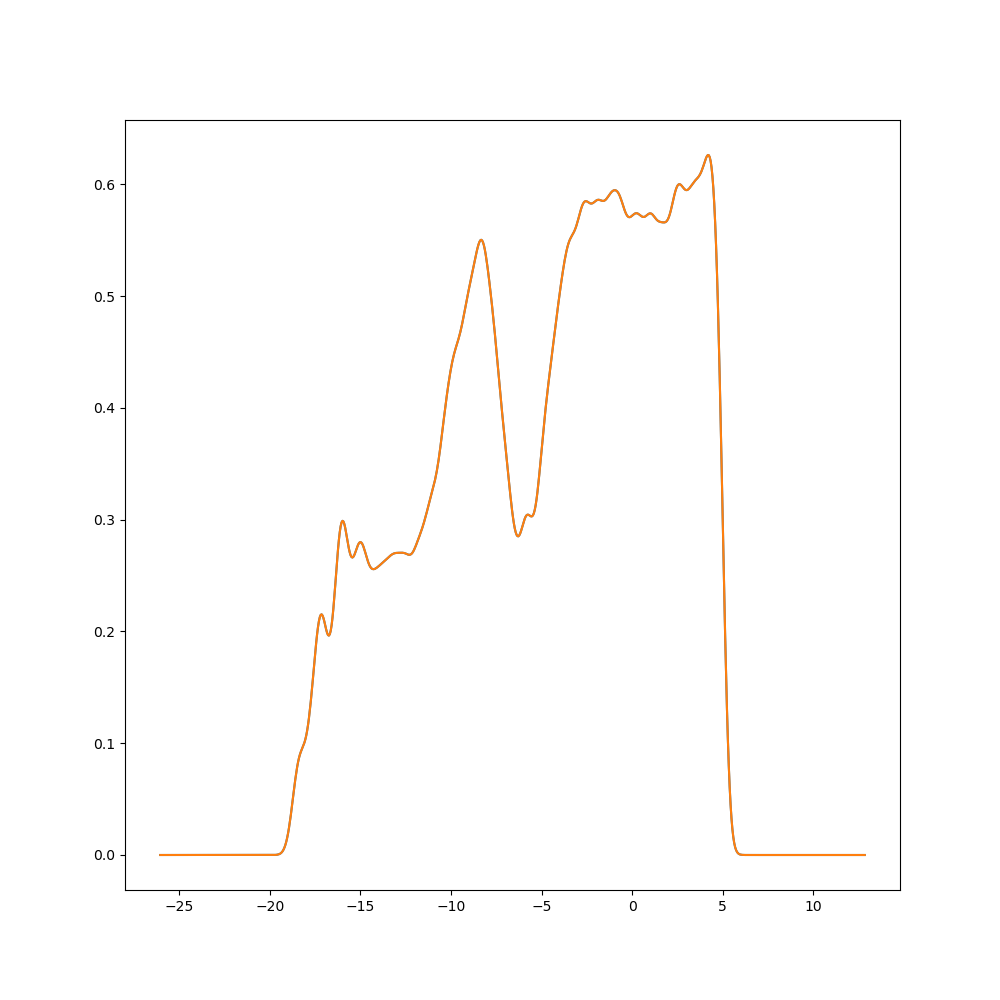

In [127]:

plt.plot(xdos, a_ldos[101])
plt.plot(xdos, ldos[train_index[101]])

In [140]:
from scipy.optimize import minimize
from sklearn.linear_model import Ridge


lowest_rmse = 10
global lowest_rmse
best_alignment = 0
global best_alignment
iteration = 0
global iteration

def a_shift_rmse(alignment):
    global iteration
    iteration +=1
    alignment = torch.tensor(alignment)
    normalized_dos = normalize(a_ldos, alignment) 
    model = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')
    model.fit(Silicon.Features['structure_avekerneldescriptors'][train_index,:], normalized_dos)
    preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][train_index,:])
    with torch.no_grad():
        rmse = loss.t_get_rmse(torch.tensor(preds), normalized_dos, xdos)
        global lowest_rmse
            
        if rmse < lowest_rmse:
            global best_alignment
            lowest_rmse = rmse
            best_alignment = alignment
            
    print ("Iteration: {}, Current error :{}, Best error: {}".format(iteration, rmse, lowest_rmse), end = "\r", flush = True)

    return rmse

rmin_a = minimize(fun = a_shift_rmse, x0 = np.zeros(831), bounds = bounds * xdos_step, method = "TNC", options ={"maxiter": 10000})

KeyboardInterrupt: 

In [132]:
start = np.zeros(831)
start[:100] += (5 * xdos_step.item())

In [133]:
start

array([0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032261,
       0.25032261, 0.25032261, 0.25032261, 0.25032261, 0.25032

In [122]:
rmin_a['x']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [1]:
best_alignment

NameError: name 'best_alignment' is not defined

## Structure-type Brute-shifts

In [81]:
bounds[324:604]

tensor([[ -89,  112],
        [-141,  144],
        [-109,  130],
        [-141,  144],
        [-115,  123],
        [-150,  147],
        [-151,  148],
        [ -77,   36],
        [-117,  107],
        [-131,  129],
        [ -97,   81],
        [ -86,   82],
        [ -80,  108],
        [ -74,  106],
        [ -99,  117],
        [ -38,   95],
        [-110,  130],
        [ -89,  112],
        [-150,  148],
        [ -45,   97],
        [-110,  130],
        [-110,  129],
        [-106,  119],
        [-106,   96],
        [-117,  137],
        [-108,  129],
        [ -58,  101],
        [-150,  147],
        [ -92,  114],
        [ -65,  118],
        [ -95,   85],
        [-102,   95],
        [-115,  123],
        [-150,  148],
        [ -55,   57],
        [-131,  130],
        [ -93,  116],
        [-104,   92],
        [-101,   91],
        [ -69,  104],
        [ -99,  116],
        [-150,  147],
        [-151,  148],
        [-108,  130],
        [ -84,   76],
        [ 

In [32]:
%matplotlib inline

In [ ]:
def t_get_BF_shift_index_mse(prediction, true, shift_range, xdos = None, perc = False):
    
    if xdos is not None:
        if len(prediction.shape) > 1:
            mse = torch.zeros(true.shape[0])
            index = torch.zeros(true.shape[0])
            for i, pred in enumerate((prediction)):
                shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[0],1), xdos, shift_range)
                mse[i], index[i] = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[0],1)),0)
            mse = torch.mean(mse, 0)

                   
        else: 
            mse = torch.zeros(1)
            index = torch.zeros(1)
            shifted_preds = consistency.shifted_ldos(prediction.repeat(shift_range.shape[0],1), xdos, shift_range)
            error_range = loss.t_get_each_mse(shifted_preds, true.repeat(shift_range.shape[0],1))
            mse, index = torch.min(error_range,0)
            
        return mse,index 
    
    else:
        raise ValueError("xdos not defined")

In [82]:
from dostools.consistency import consistency
from sklearn.linear_model import Ridge
import dostools.src.loss.loss as loss
import dostools.consistency.consistency as consistency
importlib.reload(consistency)
importlib.reload(loss)
xdos_step = xdos[1]-xdos[0]
train_rmse_list = []
total_rmse_list = []
variance_list = []
sumvar_list = []
shift_list = []
ldos2 = copy.deepcopy(ldos)
for i in tqdm(range(-150, 150 , 1)):
    

    with torch.no_grad():

        selected_index = torch.hstack([torch.arange(0,160), torch.arange(324,464)])
        ldos2[324:604] = consistency.shifted_ldos(ldos2[324:604], xdos, torch.zeros(len(ldos2[324:604])) + (i*xdos_step.item()))
        
        diamond_y = ldos2[0:160]
        betatin_y = ldos2[324:464]
        
        y = torch.vstack([diamond_y, betatin_y]) #only diamond and beta tin
        x = Silicon.Features['structure_avekerneldescriptors'][selected_index]

        model = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')
        model.fit(x,y)
        train_preds = model.predict(x)
        train_rmse = loss.t_get_mse(torch.tensor(train_preds), y, xdos)
        total_preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][:604])
        total_rmse = loss.t_get_mse(torch.tensor(total_preds), ldos2[:604], xdos)
        variance = torch.var(ldos2[:604], dim = 0, unbiased = False)
        sumvar = torch.sum(variance)
        sumvar_list.append(sumvar)
        variance_list.append(variance)
        train_rmse_list.append(train_rmse)
        total_rmse_list.append(total_rmse)
        shift_list.append(i)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:25<00:00, 11.96it/s]


In [83]:
torch.sum(variance)

tensor(24.8029)

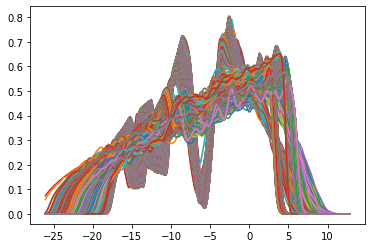

In [48]:
ldos2 = copy.deepcopy(ldos)
ldos2[324:604] = consistency.shifted_ldos(ldos2[324:604], xdos, torch.zeros(len(ldos2[324:604])) + (-47*xdos_step.item()))
for i in range(624):
    plt.plot(xdos, ldos[i])
    plt.plot(xdos, ldos2[i])

In [41]:
len(total_rmse_list)

100

In [84]:
torch.argmin(torch.tensor(train_rmse_list))

tensor(5)

In [73]:
shift_list[torch.argmax(torch.tensor(rmse_list))]

-746

In [ ]:
tri

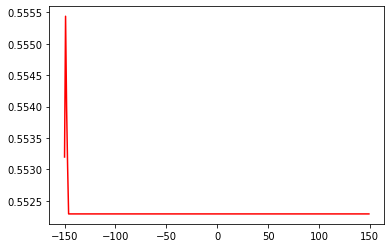

In [85]:
plt.plot(shift_list, total_rmse_list, c= 'r')
#plt.plot(shift_list, train_rmse_list, c= 'b')
#plt.plot(shift_list, sumvar_list, c = 'g')


In [86]:
torch.argmin(torch.tensor(total_rmse_list))

tensor(5)

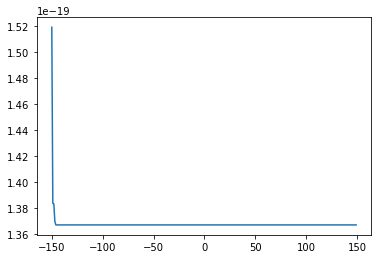

In [87]:
plt.plot(shift_list, train_rmse_list)

In [88]:
torch.argmin(torch.tensor(train_rmse_list))

tensor(5)

In [90]:
torch.argmin(torch.tensor(sumvar_list))

tensor(0)

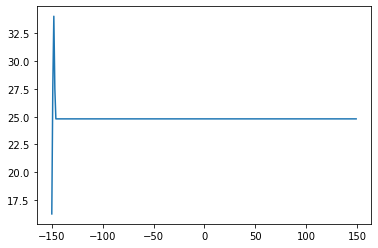

In [89]:
plt.plot(shift_list, sumvar_list)

In [49]:
torch.argmin(torch.tensor(total_rmse_list))

tensor(0)

In [170]:
rmse

tensor(0.5821)

In [145]:
model = Ridge(alpha = 0, fit_intercept = True)
model.fit()

In [ ]:
model = Ridge(alpha = 0, fit_intercept = False, solver = 'svd')
    model.fit(Silicon.Features['structure_avekerneldescriptors'][train_index,:], normalized_dos)
    
    preds = model.predict(Silicon.Features['structure_avekerneldescriptors'][train_index,:])
    with torch.no_grad():
        rmse = loss.t_get_rmse(torch.tensor(preds), normalized_dos, xdos)
        
    return rmse